# Implementing Neural Networks with Keras
* Author: Johannes Maucher
* Last Update: 29.11.2022

## What you will learn:
* Define, train and evaluate MLP in Keras
* Define, train and evaluate CNN in Keras
* Visualization of learning-curves
* Implement cross-validation in Keras
* Image classification based on the CIFAR-10 dataset, which is included in [Keras datasets](https://keras.io/datasets/).

## Imports and Configurations

In [26]:
#!pip install visualkeras
#!pip install Pillow
#!pip install tensorflow-cpu

In [27]:
#import tensorflow
#from tensorflow import keras

In [28]:
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import set_image_data_format
import os

In [29]:
set_image_data_format("channels_last")

In [30]:
import warnings
warnings.filterwarnings("ignore") 

The following code-cell is just relevant if notebook is executed on a computer with multiple GPUs. It allows to select the GPU. 

In [31]:
#from os import environ
#environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#environ["CUDA_VISIBLE_DEVICES"]="1"

In this notebook the neural network shall not learn models, which already exists. This is implemented as follows. The three models (MLP and two different CNNs) are saved to the files, whose name is assigned to the variables `mlpmodelname`, `cnnsimplemodelname` and `cnnadvancedmodelname`, respectively. 
If these files exist (checked by `os.path.isfile(filename)`) a corresponding AVAILABLE-Flag is set. If this flag is `False`, the corresponding model will be learned and saved, otherwise the existing model will be loaded from disc.

In [32]:
modeldirectory="models/"
mlpmodelname=modeldirectory+"dense512"
cnnsimplemodelname=modeldirectory+"2conv32-dense512"
cnnadvancedmodelname=modeldirectory+"2conv32-4conv64-dense512"

In [33]:
import os.path

if os.path.isdir(mlpmodelname):
    MLP_AVAILABLE=True
else:
    MLP_AVAILABLE=False
    
if os.path.isdir(cnnsimplemodelname):
    CNN1_AVAILABLE=True
else:
    CNN1_AVAILABLE=False
    
if os.path.isdir(cnnadvancedmodelname):
    CNN2_AVAILABLE=True
else:
    CNN2_AVAILABLE=False

In [34]:
CNN1_AVAILABLE

False

## Access Data 

Load the Cifar10 image dataset from `keras.datasets`. Determine the shape of the training- and the test-partition.

In [35]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [36]:
print(np.shape(X_train))
print(np.shape(X_test))

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## Visualize Data

Viusalize the first 9 images of the training-partition, using function `imshow()` from `matplotlib.pyplot`.

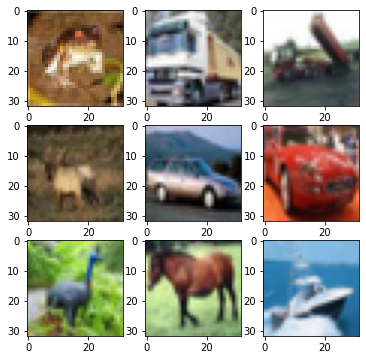

In [37]:
# create a grid of 3x3 images
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    B=X_train[i].copy()
    #B=B.swapaxes(0,2)
    #B=B.swapaxes(0,1)
    plt.imshow(B)
# show the plot
plt.show()

## Preprocessing 
Scale all images such that all their values are in the range $[0,1]$.

In [38]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

Labels of the first 9 training images:

In [39]:
print(y_train[:9])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]]


**Label-Encoding:** Transform the labels of the train- and test-partition into a one-hot-encoded representation. 

In [40]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
num_classes=len(y_train[0,:])
print(y_train[:9,:])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


## MLP
### Architecture
In Keras the architecture of neural networks can be defined in two different ways:

* Using the `Sequential` model
* Using the functional API

Below the two approaches are demonstrated. The first approach is simpler, but restricted to neural networks which consist of a linear stack of layers. The second approach is more flexible and allows to define quit complex network architectures, e.g. with more than one input, more than one output or with parallel branches.

#### Network definition option1: Using the sequential model

In [41]:
if MLP_AVAILABLE:
    model=load_model(mlpmodelname)
    print("MLP MODEL ALREADY AVAILABLE \nLOAD EXISTING MODEL")
else:
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32,3)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1573376   
                                                                 
 dense_11 (Dense)            (None, 10)                5130      
                                                                 
Total params: 1,578,506
Trainable params: 1,578,506
Non-trainable params: 0
_________________________________________________________________


In [42]:
import visualkeras

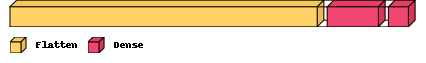

In [43]:
visualkeras.layered_view(model,legend=True)

#### Network definition option 2: Using the functional API

In [44]:
# This returns a tensor
inputs = Input(shape=(32, 32,3))
x=Flatten()(inputs)
x=Dense(512, activation='relu')(x)
x=Dense(num_classes, activation='softmax')(x)
model2 = Model(inputs=inputs, outputs=x)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_6 (Flatten)         (None, 3072)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1573376   
                                                                 
 dense_13 (Dense)            (None, 10)                5130      
                                                                 
Total params: 1,578,506
Trainable params: 1,578,506
Non-trainable params: 0
_________________________________________________________________


### Define Training Parameters 
Apply Stochastic Gradient Descent (SGD) learning, for minimizing the `categorical_crossentropy`. The performance metric shall be `accuracy`. Train the network.

In [45]:
if not MLP_AVAILABLE:
    # Compile model
    epochs = 8
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### Perform Training

In [46]:
if not MLP_AVAILABLE:
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32,verbose=False)
    model.save(mlpmodelname)
    MLP_AVAILABLE=True
else:
    print("TRAINED MODEL ALREADY AVAILABLE")

INFO:tensorflow:Assets written to: models/dense512/assets


### Evaluation 
Visualize the learning-curve on training- and test-data. 

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_style("whitegrid")
sb.set_context("notebook")

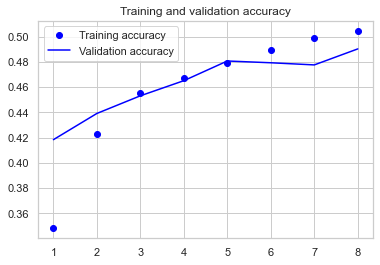

In [48]:
try:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    max_val_acc=np.max(val_acc)

    epochs = range(1, len(acc) + 1)

    plt.figure()

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()
except:
    print("LEARNING CURVE ONLY AVAILABLE IF TRAINING HAS BEEN PERFORMED IN THIS RUN")

In [49]:
loss,acc = model.evaluate(X_train,y_train, verbose=0)
print("Accuracy on Training Data : %.2f%%" % (acc*100))

Accuracy on Training Data : 51.27%


In [50]:
loss,acc = model.evaluate(X_test,y_test, verbose=0)
print("Accuracy on Test Data: %.2f%%" % (acc*100))

Accuracy on Test Data: 49.03%


## CNN 
### Define Architecture

In [51]:
if CNN1_AVAILABLE:
    model=load_model(cnnsimplemodelname)
    print("CNN SIMPLE MODEL ALREADY AVAILABLE \nLOAD EXISTING MODEL")
else:    
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32,3), padding='same',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               4194816   
                                                      

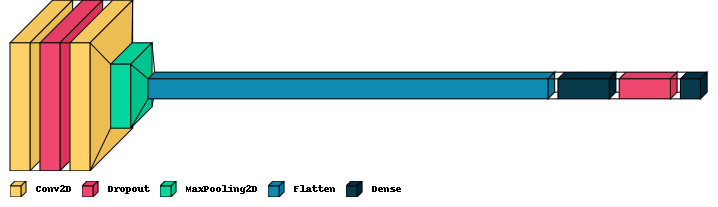

In [52]:
visualkeras.layered_view(model,legend=True)

### Define Training Parameters

In [53]:
if not CNN1_AVAILABLE:
    # Compile model
    epochs = 10
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### Perform Training

In [54]:
if not CNN1_AVAILABLE:
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
    model.save(cnnsimplemodelname)
    CNN1_AVAILABLE=True
else:
    print("TRAINED MODEL ALREADY AVAILABLE")

Epoch 1/10
1563/1563 [==============================] - 59s 38ms/step - loss: 1.7212 - accuracy: 0.3783 - val_loss: 1.4325 - val_accuracy: 0.4836
Epoch 2/10
1563/1563 [==============================] - 63s 41ms/step - loss: 1.3712 - accuracy: 0.5078 - val_loss: 1.2339 - val_accuracy: 0.5620
Epoch 3/10
1563/1563 [==============================] - 63s 41ms/step - loss: 1.2190 - accuracy: 0.5621 - val_loss: 1.1625 - val_accuracy: 0.5846
Epoch 4/10
1563/1563 [==============================] - 66s 42ms/step - loss: 1.1282 - accuracy: 0.5976 - val_loss: 1.1109 - val_accuracy: 0.6088
Epoch 5/10
1563/1563 [==============================] - 67s 43ms/step - loss: 1.0471 - accuracy: 0.6281 - val_loss: 1.0784 - val_accuracy: 0.6209
Epoch 6/10
1563/1563 [==============================] - 70s 45ms/step - loss: 0.9900 - accuracy: 0.6475 - val_loss: 1.0306 - val_accuracy: 0.6384
Epoch 7/10
1563/1563 [==============================] - 71s 45ms/step - loss: 0.9353 - accuracy: 0.6691 - val_loss: 0.9897 -

INFO:tensorflow:Assets written to: models/2conv32-dense512/assets


INFO:tensorflow:Assets written to: models/2conv32-dense512/assets


### Evaluation

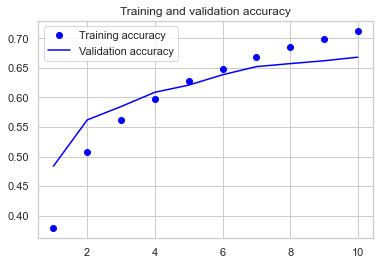

In [55]:
try:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    max_val_acc=np.max(val_acc)

    epochs = range(1, len(acc) + 1)

    plt.figure()

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()
except:
    print("LEARNING CURVE ONLY AVAILABLE IF TRAINING HAS BEEN PERFORMED IN THIS RUN")

In [56]:
loss,acc = model.evaluate(X_train,y_train, verbose=0)
print("Accuracy on Training Data : %.2f%%" % (acc*100))

Accuracy on Training Data : 78.31%


In [57]:
loss,acc = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy on Test Data: %.2f%%" % (acc*100))

Accuracy on Test Data: 66.82%


## A more complex CNN

### Architecture

In [58]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [59]:
if CNN2_AVAILABLE:
    model=load_model(cnnadvancedmodelname)
    print("CNN ADVANCED MODEL ALREADY AVAILABLE \nLOAD EXISTING MODEL")
else:  
    model = createModel()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        36928     
                                                      

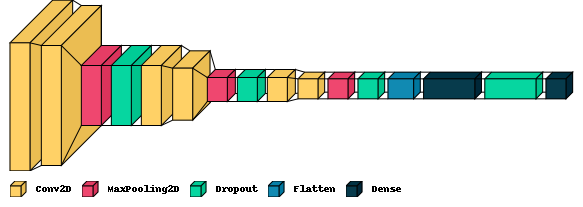

In [60]:
visualkeras.layered_view(model,legend=True)

### Define Training Parameters

In [61]:
if not CNN2_AVAILABLE:
    batch_size = 256
    epochs = 50
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Perform Training

In [62]:
if not CNN2_AVAILABLE:
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_test, y_test))
    model.save(cnnadvancedmodelname)
    CNN2_AVAILABLE=True
else:
    print("TRAINED MODEL ALREADY AVAILABLE")

INFO:tensorflow:Assets written to: models/2conv32-4conv64-dense512/assets


INFO:tensorflow:Assets written to: models/2conv32-4conv64-dense512/assets


### Evaluate

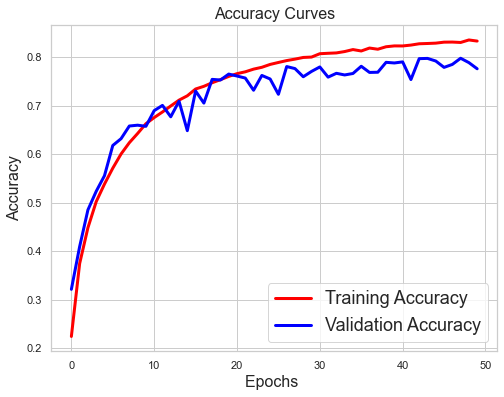

In [63]:
try:
    plt.figure(figsize=[8,6])
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.show()
except:
    print("LEARNING CURVE ONLY AVAILABLE IF TRAINING HAS BEEN PERFORMED IN THIS RUN")

In [64]:
loss,acc = model.evaluate(X_train,y_train, verbose=0)
print("Accuracy on Training Data : %.2f%%" % (acc*100))

Accuracy on Training Data : 86.97%


In [65]:
loss,acc = model.evaluate(X_test,y_test, verbose=0)
print("Accuracy on Test Data : %.2f%%" % (acc*100))

Accuracy on Test Data : 77.59%


## Visualize Feature Maps in 2nd Conv-Layer

The output of an arbitrary layer, for a given input image can be visualized as demonstrated below.

First we select and display an image, for which the featuremaps in the 2nd Convolution Layer of the previously defined and trained network shall be generated:

In [152]:
img=X_train[7:8,:,:,:]
img.shape

(1, 32, 32, 3)

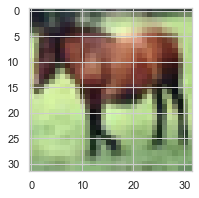

In [153]:
plt.figure(figsize=(3,3))
plt.imshow(img[0])

Next, we define a network, which contains the first 2 convolution layers of the previously trained network:

In [154]:
FirstLayer=Model(inputs=model.inputs, outputs=model.layers[1].output)
FirstLayer.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10_input (InputLayer  [(None, 32, 32, 3)]      0         
 )                                                               
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________


Then we pass the selected image to the extracted subnetwork. The output are the feature-maps of the second convolutional layer:

In [155]:
feature_maps = FirstLayer.predict(img)

1/1 [==============================] - 0s 28ms/step


There are 32 feature-maps, each of size $(32 \times 32)$:

In [156]:
feature_maps.shape

(1, 30, 30, 32)

Finally we visualize these 32 feature-maps:

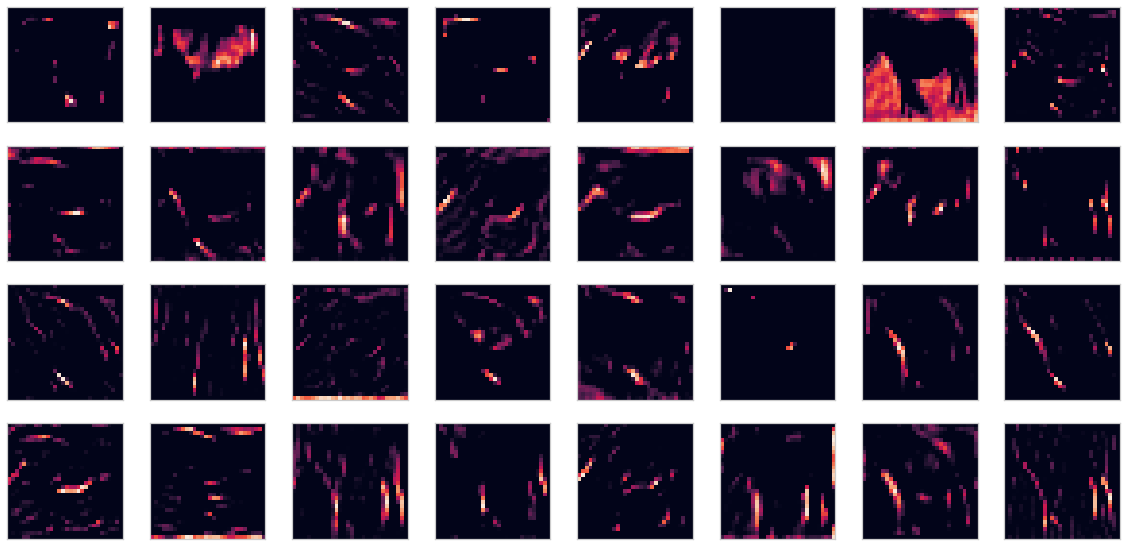

In [157]:
square = 8
ix = 1
plt.figure(figsize=(20,20))
for _ in range(8):
    for _ in range(4):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1])
        ix += 1
plt.show()